# Solve for Gaussian approximations using optimization

This uses the old functions for solving the optimization process

In [3]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess 
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-11-03 16:14:11.436713: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 16:14:12.014203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


In [39]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
num_patches = 20000 

channel = 'LED119'
eigenvalue_floor = 1e0

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)


seed = 10

patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


KeyboardInterrupt: 

## optimize to improve fit

building toeplitz mat: 100%|██████████| 19/19 [00:00<00:00, 26.73it/s]
Computing loss: 8it [00:00, 14.41it/s]


Initial validation NLL: 1289.51


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]
Computing loss: 8it [00:00, 105.28it/s]


Epoch 1: validation NLL: 4.56


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]
Computing loss: 8it [00:00, 106.53it/s]


Epoch 2: validation NLL: 4.56


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
Computing loss: 8it [00:00, 111.20it/s]


Epoch 3: validation NLL: 4.56


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.57it/s]
Computing loss: 8it [00:00, 108.46it/s]


Epoch 4: validation NLL: 4.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 47.14it/s]
Computing loss: 8it [00:00, 113.65it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]
Computing loss: 8it [00:00, 114.69it/s]


Epoch 6: validation NLL: 4.55


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s]
Computing loss: 8it [00:00, 102.59it/s]


Epoch 7: validation NLL: 4.55


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
Computing loss: 8it [00:00, 107.30it/s]


Epoch 8: validation NLL: 4.56


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 47.88it/s]
Computing loss: 8it [00:00, 105.45it/s]


Epoch 9: validation NLL: 4.55


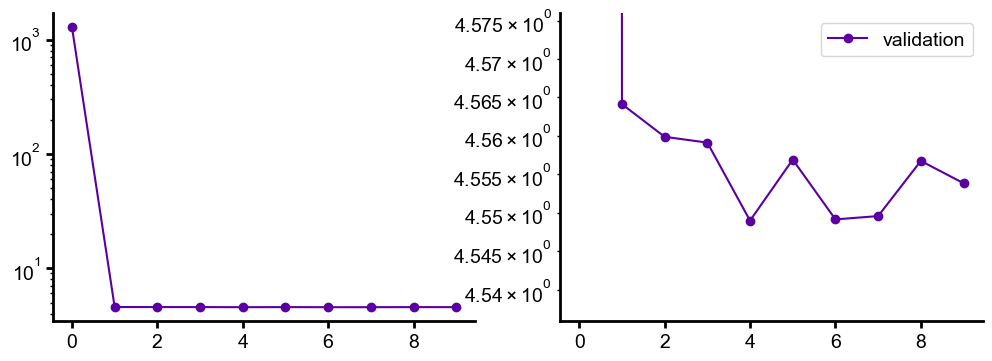

In [ ]:
gp = StationaryGaussianProcess(patches, eigenvalue_floor=1e-3, verbose=True)
initial_cov_mat = gp.get_cov_mat()
val_loss_history = gp.fit(patches, verbose=True)
optimized_cov_mat = gp.get_cov_mat()

plot_optimization_loss_history(val_loss_history)

In [ ]:
cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, validation_loss_history, final_cov_mat = fit_optimized_gaussian(
    patches, eigenvalue_floor=1e-3, return_everything=True, num_validation=100, verbose=True, patience=5)
print (f'optimized loss: {best_loss}')

Initial loss:  1424.1532987001888


KeyboardInterrupt: 

Text(0, 0.5, 'Eigenvalue')

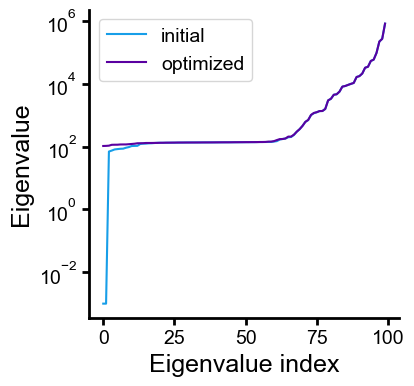

In [ ]:
# plot eignevalues of different cov mats
eig_vals_initial = np.linalg.eigvalsh(initial_cov_mat)
eig_vals_optimized = np.linalg.eigvalsh(optimized_cov_mat)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.semilogy(eig_vals_initial, label='initial')
axs.semilogy(eig_vals_optimized, label='optimized')
axs.legend()

clear_spines(axs)
axs.set_xlabel('Eigenvalue index')
axs.set_ylabel('Eigenvalue')

In [ ]:
from encoding_information.models.gaussian_process import average_diagonals_to_make_doubly_toeplitz
# check that it succeeded in getting a doubly toeplitz matrix
dt = average_diagonals_to_make_doubly_toeplitz(optimized_cov_mat, patch_size)
negative_evs = np.all(np.linalg.eigvalsh(dt) < 0)
if negative_evs:
    raise ValueError('not positive definite')
print('it is positive definite')

it is positive definite


## Generate samles using unoptimized and optimized covariance matrices

Text(0.5, 0.98, 'Sample size: 40, patch_size: 10')

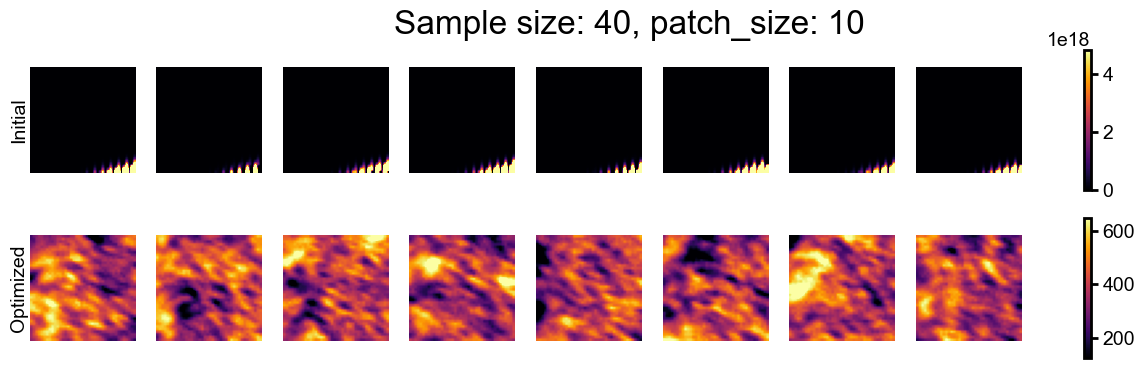

In [ ]:
sample_size = 40
num_samples = 8

gp = StationaryGaussianProcess(patches, eigenvalue_floor=1e-3, verbose=True)
samples_initial = gp.generate_samples(num_samples, sample_size=sample_size)
initial_cov_mat = gp.get_cov_mat()
initial_nll = gp.compute_negative_log_likelihood(test_patches)
val_loss_history = gp.fit(patches, verbose=True)
samples_optimized = gp.generate_samples(num_samples, sample_size=sample_size)
optimized_cov_mat = gp.get_cov_mat()
optimized_nll = gp.compute_negative_log_likelihood(test_patches)

fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4), sharex=True, sharey=True)
vmin_initial, vmax_initial = np.percentile(samples_initial, 1), np.percentile(samples_initial, 99)
vmin_optimized, vmax_optimized = np.percentile(samples_optimized, 1), np.percentile(samples_optimized, 99)
for i in range(num_samples):
    im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_initial, vmax=vmax_initial)
    im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    axs[0, i].axis('off')
    axs[1, i].axis('off')

# add new text to the left of each row
for ax, row in zip(axs[:, 0], ['Initial', 'Optimized']):
    ax.text(-0.1, 0.5, row, va='center', ha='center', rotation=90, rotation_mode='anchor', transform=ax.transAxes)

# add colorbars
fig.colorbar(im1, ax=axs[0, :], location='right')
fig.colorbar(im2, ax=axs[1, :], location='right')

fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}')

Text(0, 0.5, 'Eigenvalue')

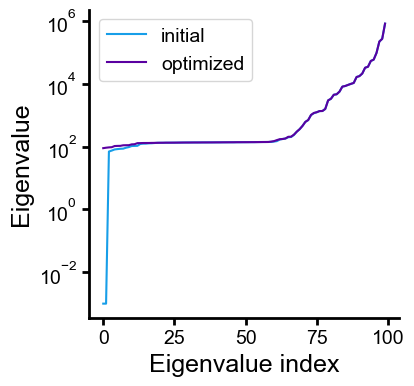

In [ ]:
# plot eignevalues of different cov mats
eig_vals_initial = np.linalg.eigvalsh(initial_cov_mat)
eig_vals_optimized = np.linalg.eigvalsh(optimized_cov_mat)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.semilogy(eig_vals_initial, label='initial')
axs.semilogy(eig_vals_optimized, label='optimized')
axs.legend()

clear_spines(axs)
axs.set_xlabel('Eigenvalue index')
axs.set_ylabel('Eigenvalue')

In [ ]:
print(f'Initial NLL: {initial_nll}')
print(f'Optimized NLL: {optimized_nll}')

Initial NLL: 1485.969783027022
Optimized NLL: 4.556322912076165


## Improve with preconditioning

In [4]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 1000
num_patches = 1000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 15

channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

# # cov_mat = estimate_full_cov_mat(patches)
# gp = StationaryGaussianProcess(patches)
# gp.fit(patches)
# true_cov_mat_px = gp.get_cov_mat()
# true_mean_px = np.mean(images)
# samples = gp.generate_samples(num_samples=num_patches, sample_shape=patch_size, ensure_nonnegative=True)

In [7]:
# gaussian_sigma = 50

# noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)

s = 8
print('seed ', s)
onp.random.seed(s)
subsample_indices = onp.random.choice(np.arange(patches.shape[0]), 40, replace=False)
subsample = patches[subsample_indices]



seed  8


In [6]:
# subsample = noisy_samples[:150]
# randomly pick a subset


gp = StationaryGaussianProcess(subsample, eigenvalue_floor=1e-4, verbose=True)
# gp.fit(subsample, precondition_gradient=False)
gp.fit(subsample, precondition_gradient=False, batch_size=12, learning_rate=1e0, gradient_clip=1e10, momentum=0.9, patience=20, num_val_samples=10)



building toeplitz mat: 100%|██████████| 29/29 [00:01<00:00, 25.44it/s]
2023-11-03 16:14:38.171741: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 331746.26


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


Epoch 1: validation NLL: 16698520.53


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


Epoch 2: validation NLL: 58380.82


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s]


Epoch 3: validation NLL: 32330.45


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.58it/s]


Epoch 4: validation NLL: 10.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s]


Epoch 5: validation NLL: 10.69


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 34.36it/s]


Epoch 6: validation NLL: 10.79


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


Epoch 7: validation NLL: 10.87


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 37.68it/s]


Epoch 8: validation NLL: 10.93


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 9: validation NLL: 10.98


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


Epoch 10: validation NLL: 11.01


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Epoch 11: validation NLL: 11.05


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]


Epoch 12: validation NLL: 11.07


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 43.42it/s]


Epoch 13: validation NLL: 11.10


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 43.73it/s]


Epoch 14: validation NLL: 11.12


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 42.95it/s]


Epoch 15: validation NLL: 11.14


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 43.55it/s]


Epoch 16: validation NLL: 11.15


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 43.71it/s]


Epoch 17: validation NLL: 11.16


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 42.58it/s]


Epoch 18: validation NLL: 11.18


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]


Epoch 19: validation NLL: 11.19


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 42.73it/s]


Epoch 20: validation NLL: 11.20


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 43.10it/s]


Epoch 21: validation NLL: 11.20


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 41.73it/s]

Epoch 22: validation NLL: 11.21



Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 43.09it/s]


Epoch 23: validation NLL: 11.22


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 42.59it/s]


Epoch 24: validation NLL: 11.22


[331746.25799477915,
 16698520.531365698,
 58380.81968944975,
 32330.452472309942,
 10.531133337917998,
 10.686156977488343,
 10.793174161930642,
 10.870181453384621,
 10.930788484884648,
 10.977063751655615,
 11.013610605881901,
 11.046719174191205,
 11.074962789030248,
 11.09885998243778,
 11.11894899519021,
 11.136387114632639,
 11.151786128549816,
 11.164885227082776,
 11.17623752604986,
 11.18637141007571,
 11.195394055380563,
 11.203342122828326,
 11.210380616651964,
 11.216608665791432,
 11.222182718632201]